### Universidad del Valle de Guatemala
## Facultad de Ingeniería
## Departamento de Ciencias de la Computación
## Curso: Security Data Science
# Juan Pablo Pineda
# Carnet: 19087

### Proyecto 2: Aprendizaje Continuo


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score

In [2]:
df_processed = pd.read_csv('Data/processed.csv')

print(df_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 21 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   cc_num                        int64  
 1   category                      int64  
 2   amt                           float64
 3   gender                        int64  
 4   state                         int64  
 5   zip                           int64  
 6   is_fraud                      int64  
 7   amt_month                     float64
 8   amt_year                      float64
 9   amt_month_shopping_net_spend  float64
 10  count_month_shopping_net      float64
 11  first_time_at_merchant        int64  
 12  hour_of_day                   int64  
 13  day_of_week                   int64  
 14  month                         int64  
 15  year                          int64  
 16  avg_transaction_amt           float64
 17  transaction_count             int64  
 18  std_transaction_amt   

## Set de funciones utiles para la implementacion de los modelos

Esta funcion hace el preprocesamiento y sampleo de la data, especificamente para el modelo de LGBM ya que el de SVM requiere otro tipo de procesamiento para aplicar mejor el aprendizaje continuo 

In [3]:
def getProcessedData(df):
    X = df.drop(columns=['is_fraud'])
    y = df['is_fraud']
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    X_train_dev, X_test, y_train_dev, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

    X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.176, random_state=42)

    non_fraud_count = len(y_train[y_train == 0])
    fraud_count = non_fraud_count // 5

    sampling_strategy = {0: non_fraud_count, 1: fraud_count}

    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    XTrainRsmp, yTrainRsmp = smote.fit_resample(X_train, y_train)

    return XTrainRsmp, yTrainRsmp, X_test, y_test, X_dev, y_dev

Funcion para el preprocesamiento y sampleo de la data para XBGB

In [4]:
def getProcessedDataForXGBoost(df):
    X = df.drop(columns=['is_fraud'])
    y = df['is_fraud']
    
    # Imputación de valores faltantes
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
    
    # Cálculo de scale_pos_weight para manejo de clases desbalanceadas
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    return X_train, y_train, X_test, y_test, scale_pos_weight


Funciones para medir el rendimiento y el recall de los modelos, será útil para hacer la comparación de los mismos al final del trabajo.

In [5]:
def modelPerformance(model, dtest, y_test, model_name):
    yPredProb = model.predict(dtest)

    fpr, tpr, thresholdsRoc = roc_curve(y_test, yPredProb)
    optimalIdxRoc = np.argmax(tpr - fpr)
    optimalThresholdRoc = thresholdsRoc[optimalIdxRoc]

    yPredProb = model.predict(dtest)
    y_pred = [1 if pred > optimalThresholdRoc else 0 for pred in yPredProb]

    print(f"Rendimiento del modelo {model_name}:")
    print("ROC:", roc_auc_score(y_test, yPredProb))
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    
    confMatrix = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusión:")
    print(confMatrix)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confMatrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Non-Fraud", "Fraud"], 
                yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel("Predicho")
    plt.ylabel("Actual")
    plt.title(f"Matriz de confusión - {model_name}")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, yPredProb)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, yPredProb)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')
    plt.title(f'(ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='green', lw=2, label='Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

### Entrenamiento Inicial

Se eligió 2019 como dataset inicial ya que este fue el año mas normal en términos de economía global, ya que en 2020, esta se vio afectada por la pandemia de COVID-19.

In [7]:
dfSubset2019 = df_processed[df_processed['year'] == 2019]

XTrainRsmp, yTrainRsmp, X_test, y_test, X_dev, y_dev = getProcessedData(dfSubset2019)
XTrainXBGB, yTrainXBGB, X_test_xbg, y_test_xbg, scale_pos_weight = getProcessedDataForXGBoost(dfSubset2019)


## Implementación de Modelos


LGBM

Rendimiento del modelo LightGBM:
ROC: 0.9977734015265638
Accuracy:  0.9828585433366012
Recall: 0.9740420271940667
F1-score: 0.398583712696004
Matriz de Confusión:
[[135562   2357]
 [    21    788]]


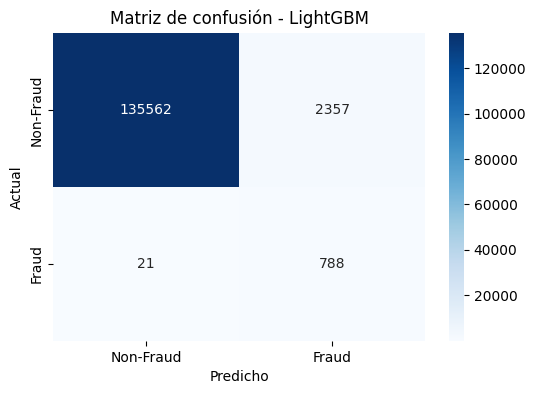

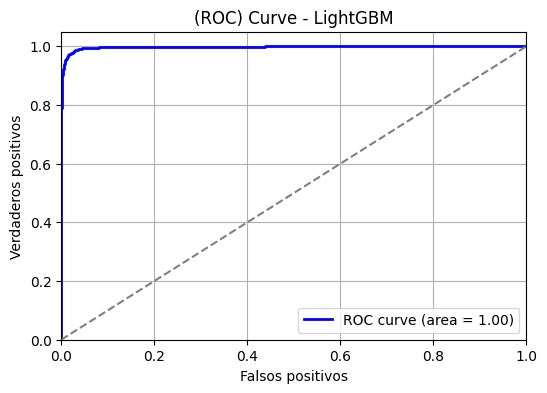

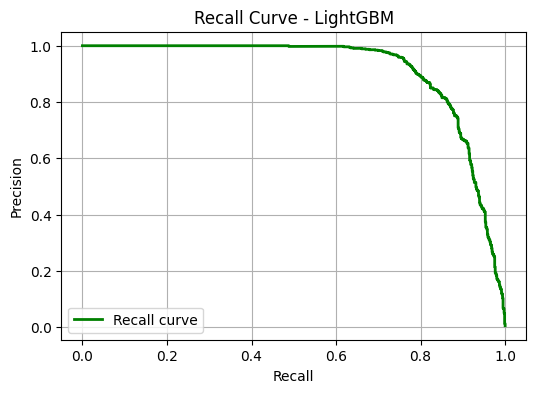

In [8]:
train_data_batch = lgb.Dataset(XTrainRsmp, label=yTrainRsmp)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1,
}

# Configurar el número de rondas
num_rounds_batch = 100
lgmbModel = lgb.train(params, train_data_batch, num_boost_round=num_rounds_batch)

# Guardar el modelo
lgmbModel.save_model('Models/lgb_model_2019.txt')

modelPerformance(lgmbModel, X_test, y_test, "LightGBM")

XBG Boost

In [9]:
XBGparams = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:09:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost:
ROC: 0.9984333488773972
Accuracy:  0.9805860409796183
Recall: 0.9877819548872181
F1-score: 0.3692253644826981
Matriz de Confusión:
[[180328   3578]
 [    13   1051]]


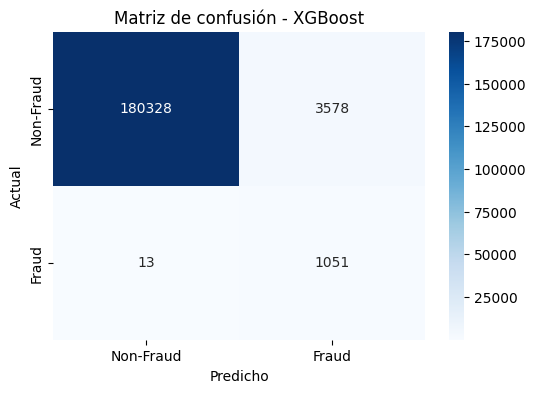

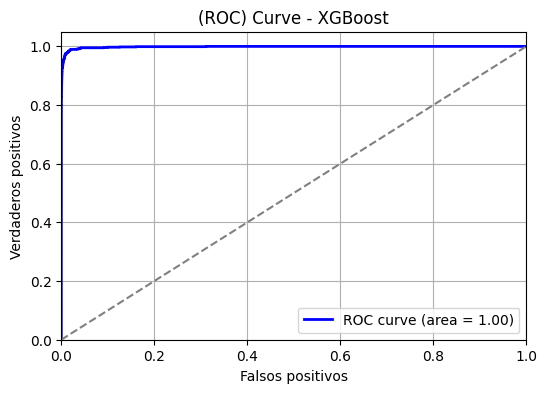

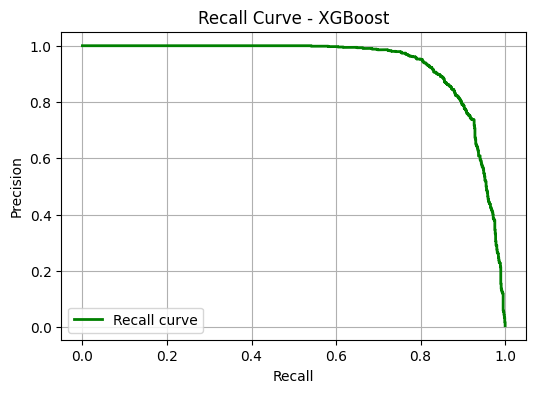

In [10]:
dtrain = xgb.DMatrix(XTrainXBGB, label=yTrainXBGB)
dtest_2019 = xgb.DMatrix(X_test_xbg, label=y_test_xbg)

# Entrenamiento del modelo
xbgbModel = xgb.train(XBGparams, dtrain, num_boost_round=100)

# Guardar el modelo
xbgbModel.save_model('Models/xgb_model_2019.txt')

modelPerformance(xbgbModel, dtest_2019, y_test_xbg, "XGBoost")

### Batch 1 - Primer trimestre 2020

In [66]:
dfSubset2020 = df_processed[(df_processed['year'] == 2020) & (df_processed['month'] >= 1) & (df_processed['month'] <= 3)]

XTrainRsmp_batch, yTrainRsmp_batch, X_test_batch, y_test_batch, X_dev_batch, y_dev_batch = getProcessedData(dfSubset2020)
XTrainXBGB_batch, yTrainXBGB_batch, X_test_xbg_batch, y_test_xbg_batch, scale_pos_weight_batch = getProcessedDataForXGBoost(dfSubset2020)

LGBM

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Rendimiento del modelo LightGBM 1:
ROC: 0.9964485780252809
Accuracy:  0.9841092297604813
Recall: 0.9655172413793104
F1-score: 0.44919786096256686
Matriz de Confusión:
[[25347   406]
 [    6   168]]


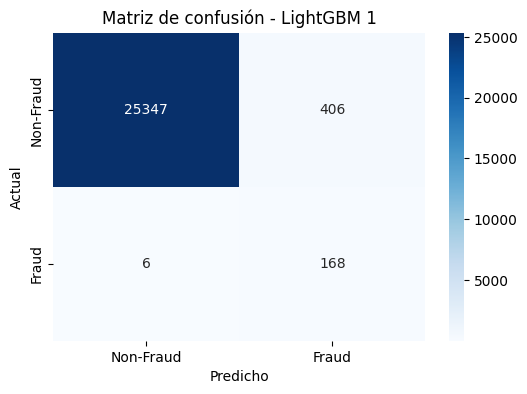

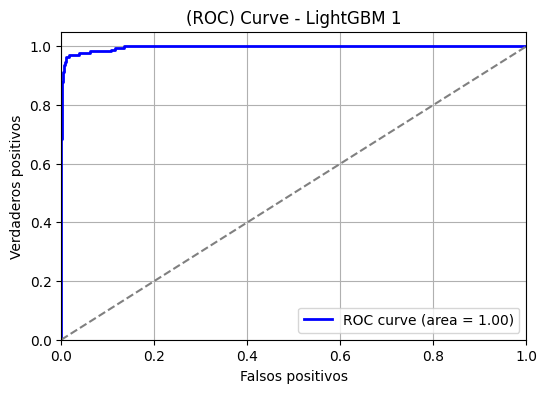

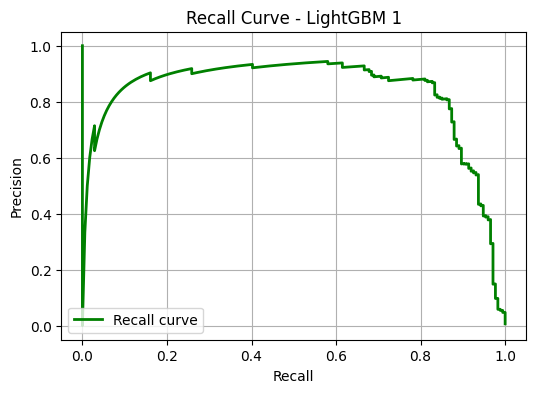

In [67]:
lgbmModelIncremental = lgb.Booster(model_file='Models/lgb_model_2019.txt')

params = lgbmModelIncremental.params

params.pop('early_stopping_round', None)

trainDataBatch = lgb.Dataset(XTrainRsmp_batch, label=yTrainRsmp_batch)

num_rounds_batch = 100
lgbmModelIncremental = lgb.train(params, trainDataBatch, num_boost_round=num_rounds_batch, init_model=lgbmModelIncremental)

lgbmModelIncremental.save_model('Models/lgb_model_2020_1.txt')

modelPerformance(lgbmModelIncremental, X_test_batch, y_test_batch, "LightGBM 1")

XBGB Boost

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost 1:
ROC: 0.9997889320058648
Accuracy:  0.99140848737308
Recall: 0.9914893617021276
F1-score: 0.6107470511140236
Matriz de Confusión:
[[34039   295]
 [    2   233]]


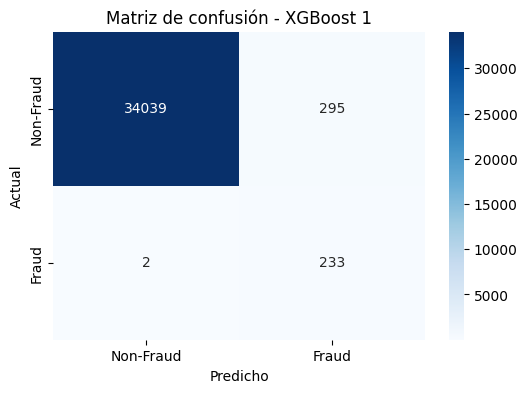

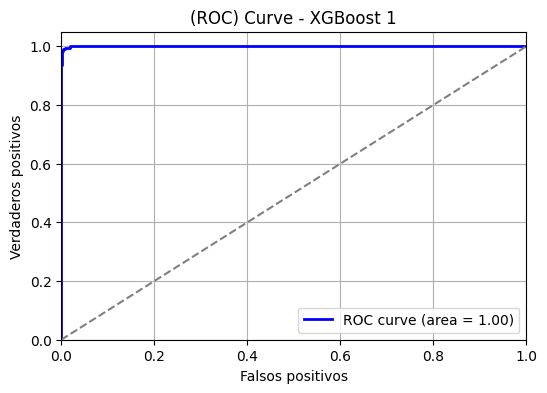

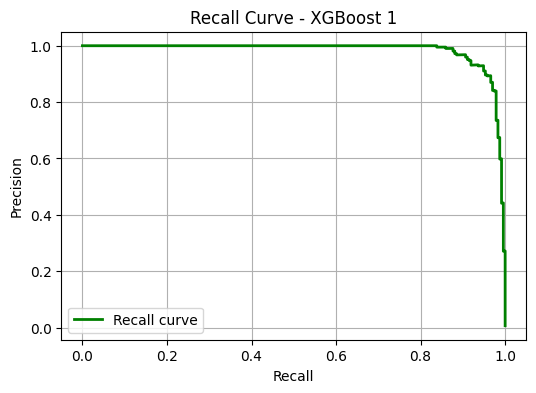

In [68]:
xbgbModelIncremental = xgb.Booster(model_file='Models/xgb_model_2019.txt')

dtrain = xgb.DMatrix(XTrainXBGB_batch, label=yTrainXBGB_batch)
dtest_2020_1 = xgb.DMatrix(X_test_xbg_batch, label=y_test_xbg_batch)

xbgbModelIncremental = xgb.train(XBGparams, dtrain, num_boost_round=100, xgb_model=xbgbModelIncremental)

xbgbModelIncremental.save_model('Models/xgb_model_2020_1.txt')

modelPerformance(xbgbModelIncremental, dtest_2020_1, y_test_xbg_batch, "XGBoost 1")

### Batch 2 - segundo trimestre 2020


In [69]:
dfSubset2020Batch2 = df_processed[(df_processed['year'] == 2020) & (df_processed['month'] >= 4) & (df_processed['month'] <= 6)]

XTrainRsmp_batch2, yTrainRsmp_batch2, X_test_batch2, y_test_batch2, X_dev_batch2, y_dev_batch2 = getProcessedData(dfSubset2020Batch2)
XTrainXBGB_batch2, yTrainXBGB_batch2, X_test_xbg_batch2, y_test_xbg_batch2, scale_pos_weight_batch2 = getProcessedDataForXGBoost(dfSubset2020Batch2)

LGBM

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Rendimiento del modelo LightGBM 1:
ROC: 0.9772278114993069
Accuracy:  0.9782861799976714
Recall: 0.9387755102040817
F1-score: 0.3303411131059246
Matriz de Confusión:
[[33426   734]
 [   12   184]]


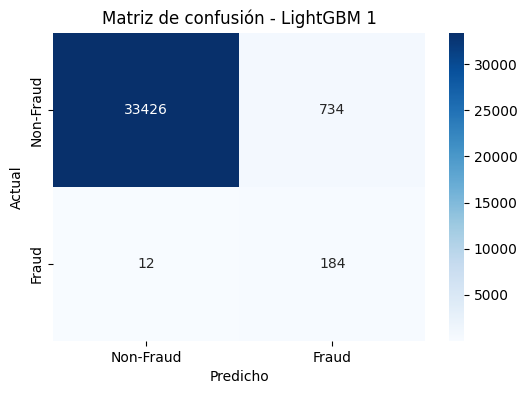

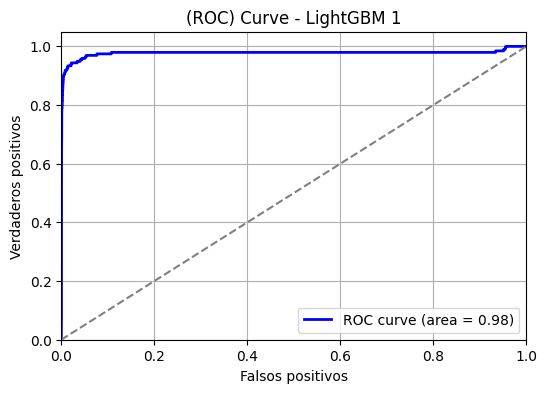

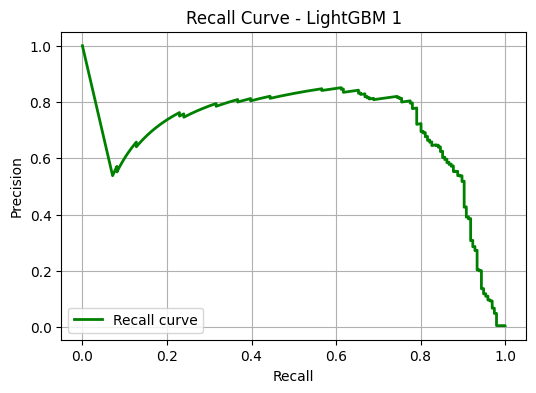

In [70]:
lgmbModel_incremental2 = lgb.Booster(model_file='Models/lgb_model_2020_1.txt')

params = lgmbModel_incremental2.params

params.pop('early_stopping_round', None)

train_data_batch2 = lgb.Dataset(XTrainRsmp_batch2, label=yTrainRsmp_batch2)

num_rounds_batch2 = 100
lgmbModel_incremental2 = lgb.train(params, train_data_batch2, num_boost_round=num_rounds_batch2, init_model=lgmbModel_incremental2)

lgmbModel_incremental2.save_model('Models/lgb_model_2020_2.txt')

modelPerformance(lgmbModel_incremental2, X_test_batch2, y_test_batch2, "LightGBM 1")

XBGB Boost

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost 1:
ROC: 0.9951439078619619
Accuracy:  0.9886919315403423
Recall: 0.9770992366412213
F1-score: 0.4970873786407767
Matriz de Confusión:
[[45034   512]
 [    6   256]]


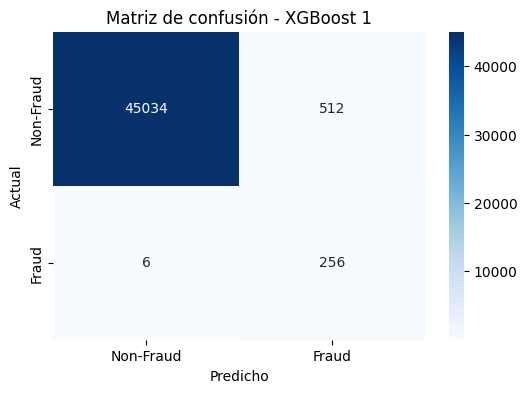

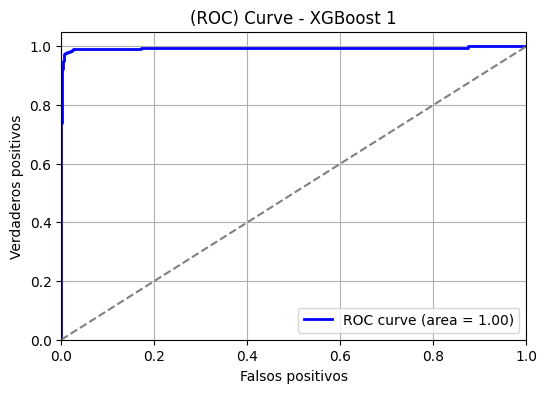

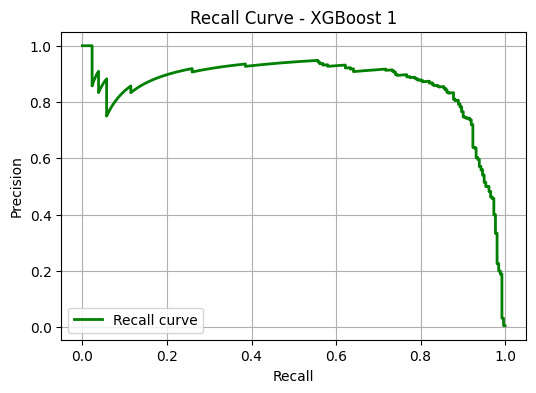

In [71]:
xbgbModelIncremental2 = xgb.Booster(model_file='Models/xgb_model_2020_1.txt')

dtrain = xgb.DMatrix(XTrainXBGB_batch2, label=yTrainXBGB_batch2)
dtest_2020_2 = xgb.DMatrix(X_test_xbg_batch2, label=y_test_xbg_batch2)

xbgbModelIncremental2 = xgb.train(XBGparams, dtrain, num_boost_round=100, xgb_model=xbgbModelIncremental2)

xbgbModelIncremental2.save_model('Models/xgb_model_2020_2.txt')

modelPerformance(xbgbModelIncremental2, dtest_2020_2, y_test_xbg_batch2, "XGBoost 1")

### Batch 3 - 3er trimestre 2020


In [72]:
dfSubset2020Batch3 = df_processed[(df_processed['year'] == 2020) & (df_processed['month'] >= 7) & (df_processed['month'] <= 9)]

XTrainRsmp_batch3, yTrainRsmp_batch3, X_test_batch3, y_test_batch3, X_dev_batch3, y_dev_batch3 = getProcessedData(dfSubset2020Batch3)
XTrainXBGB_batch3, yTrainXBGB_batch3, X_test_xbg_batch3, y_test_xbg_batch3, scale_pos_weight_batch3 = getProcessedDataForXGBoost(dfSubset2020Batch3)

LGBM

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Rendimiento del modelo LightGBM 1:
ROC: 0.8732331339894576
Accuracy:  0.9743043608858305
Recall: 0.8048780487804879
F1-score: 0.21908713692946058
Matriz de Confusión:
[[35548   909]
 [   32   132]]


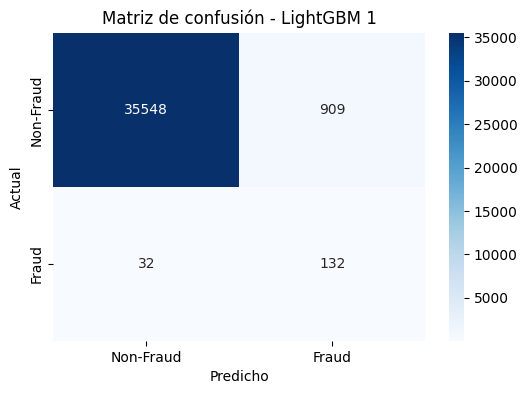

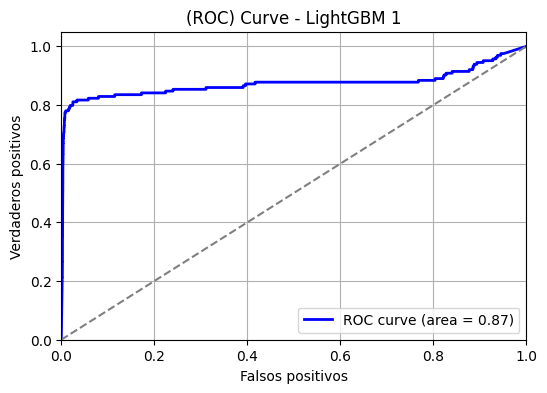

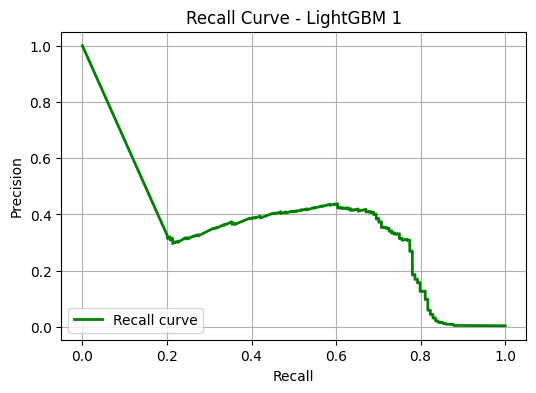

In [73]:
lgmbModel_incremental3 = lgb.Booster(model_file='Models/lgb_model_2020_2.txt')

params = lgmbModel_incremental3.params

params.pop('early_stopping_round', None)

train_data_batch3 = lgb.Dataset(XTrainRsmp_batch3, label=yTrainRsmp_batch3)

num_rounds_batch3 = 100
lgmbModel_incremental3 = lgb.train(params, train_data_batch3, num_boost_round=num_rounds_batch3, init_model=lgmbModel_incremental3)

lgmbModel_incremental3.save_model('Models/lgb_model_2020_3.txt')

modelPerformance(lgmbModel_incremental3, X_test_batch3, y_test_batch3, "LightGBM 1")

XBGB Boost

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost 1:
ROC: 0.9895358187134503
Accuracy:  0.9815065126566724
Recall: 0.9517543859649122
F1-score: 0.32460732984293195
Matriz de Confusión:
[[47708   892]
 [   11   217]]


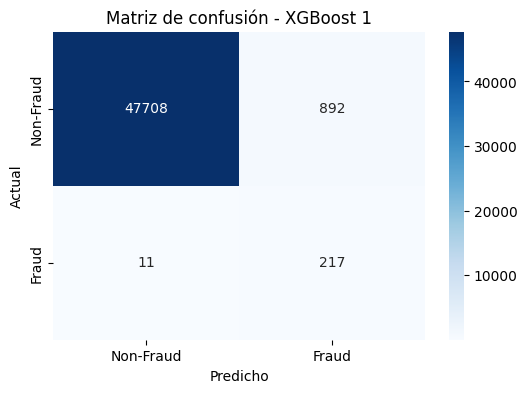

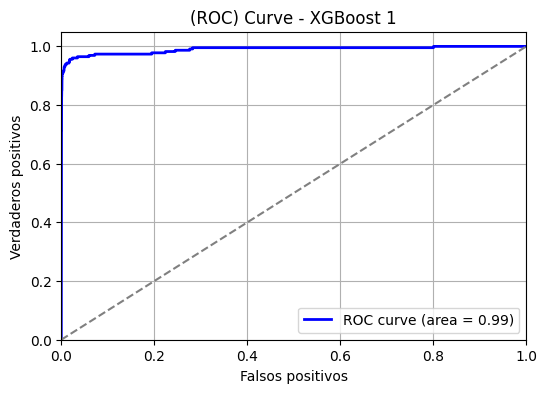

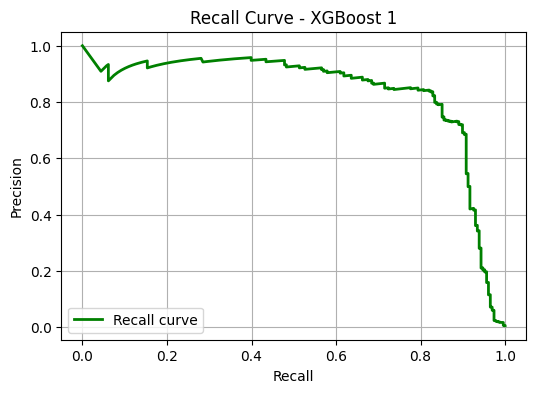

In [74]:
xbgbModelIncremental3 = xgb.Booster(model_file='Models/xgb_model_2020_2.txt')

dtrain = xgb.DMatrix(XTrainXBGB_batch3, label=yTrainXBGB_batch3)
dtest_2020_3 = xgb.DMatrix(X_test_xbg_batch3, label=y_test_xbg_batch3)

xbgbModelIncremental3 = xgb.train(XBGparams, dtrain, num_boost_round=100, xgb_model=xbgbModelIncremental3)

xbgbModelIncremental3.save_model('Models/xgb_model_2020_3.txt')

modelPerformance(xbgbModelIncremental3, dtest_2020_3, y_test_xbg_batch3, "XGBoost 1")

### Batch 4 - 4to trimestre 2020


In [75]:
dfSubset2020Batch4 = df_processed[(df_processed['year'] == 2020) & (df_processed['month'] >= 7) & (df_processed['month'] <= 9)]

XTrainRsmp_batch4, yTrainRsmp_batch4, X_test_batch4, y_test_batch4, X_dev_batch4, y_dev_batch4 = getProcessedData(dfSubset2020Batch4)
XTrainXBGB_batch4, yTrainXBGB_batch4, X_test_xbg_batch4, y_test_xbg_batch4, scale_pos_weight_batch4 = getProcessedDataForXGBoost(dfSubset2020Batch4)

LGBM

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Rendimiento del modelo LightGBM 1:
ROC: 0.8675671706795243
Accuracy:  0.9824963818574042
Recall: 0.7804878048780488
F1-score: 0.2853957636566332
Matriz de Confusión:
[[35852   605]
 [   36   128]]


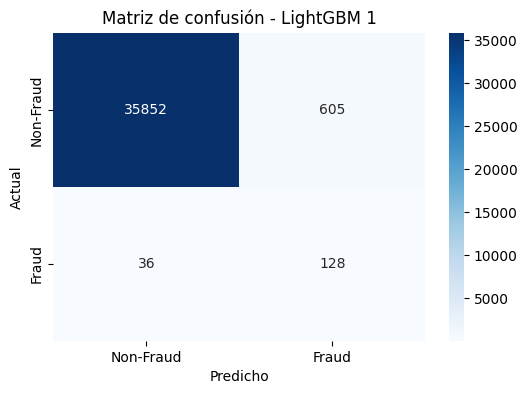

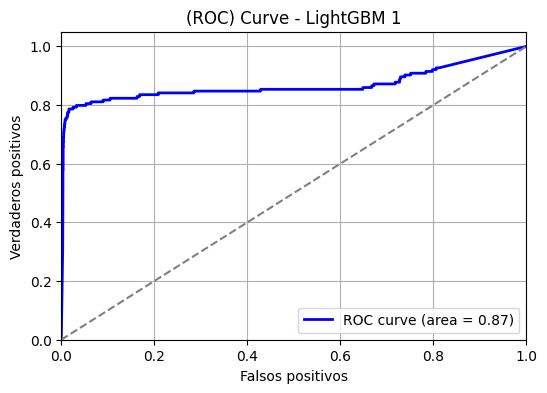

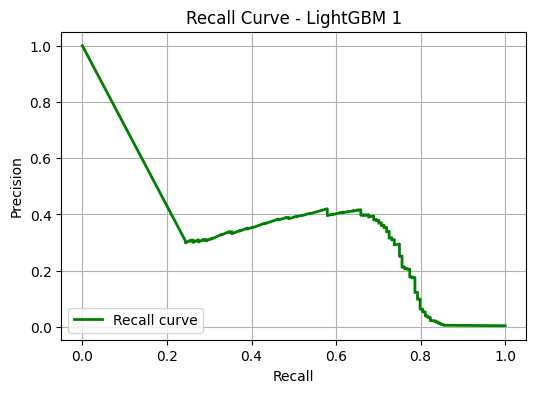

In [76]:
lgmbModel_incremental4 = lgb.Booster(model_file='Models/lgb_model_2020_3.txt')

params = lgmbModel_incremental4.params

params.pop('early_stopping_round', None)

train_data_batch4 = lgb.Dataset(XTrainRsmp_batch3, label=yTrainRsmp_batch3)

num_rounds_batch4 = 100
lgmbModel_incremental4 = lgb.train(params, train_data_batch4, num_boost_round=num_rounds_batch4, init_model=lgmbModel_incremental4)

lgmbModel_incremental4.save_model('Models/lgb_model_2020_4.txt')

modelPerformance(lgmbModel_incremental4, X_test_batch4, y_test_batch4, "LightGBM 1")

XBGB Boost

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost 1:
ROC: 0.9911598440545808
Accuracy:  0.9894937331039567
Recall: 0.9605263157894737
F1-score: 0.46056782334384855
Matriz de Confusión:
[[48096   504]
 [    9   219]]


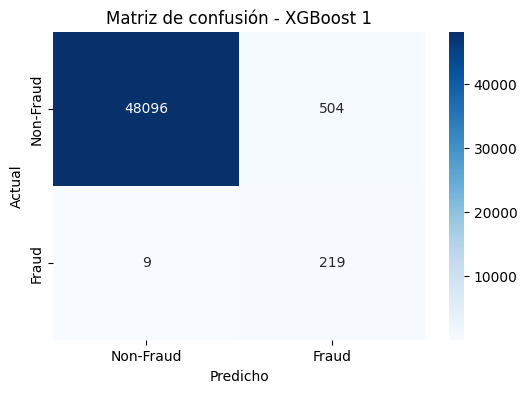

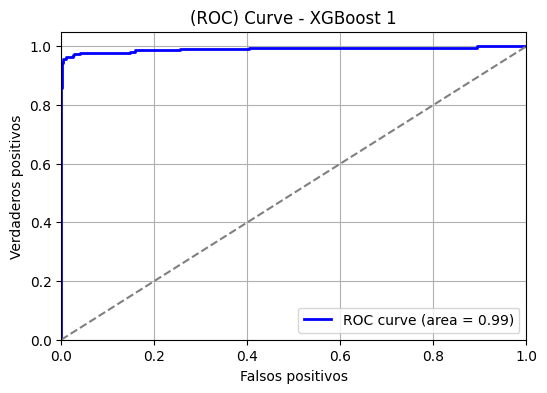

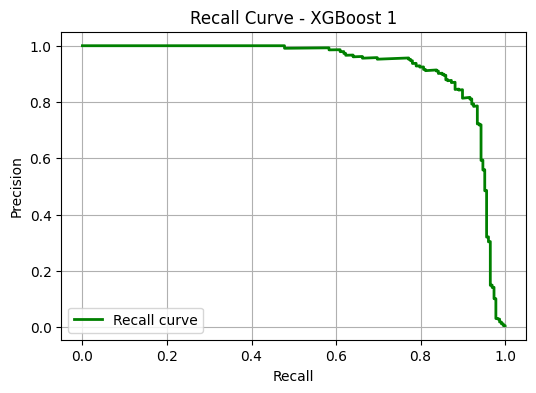

In [77]:
xbgbModelIncremental4 = xgb.Booster(model_file='Models/xgb_model_2020_1.txt')

dtrain = xgb.DMatrix(XTrainXBGB_batch4, label=yTrainXBGB_batch4)
dtest_2020_4 = xgb.DMatrix(X_test_xbg_batch4, label=y_test_xbg_batch4)

xbgbModelIncremental4 = xgb.train(XBGparams, dtrain, num_boost_round=100, xgb_model=xbgbModelIncremental4)

xbgbModelIncremental4.save_model('Models/xgb_model_2020_3.txt')

modelPerformance(xbgbModelIncremental4, dtest_2020_4, y_test_xbg_batch4, "XGBoost 1")

### Toda la data

In [78]:
dfSubsetAll = df_processed.copy()

XTrainRsmp_all, yTrainRsmp_all, X_test_all, y_test_all, X_dev_all, y_dev_all = getProcessedData(dfSubsetAll)
XTrainXBGB_all, yTrainXBGB_all, X_test_xbg_all, y_test_xbg_all, scale_pos_weight_all = getProcessedDataForXGBoost(dfSubsetAll)

LGBM

In [79]:
trainDataBatch = lgb.Dataset(XTrainRsmp_all, label=yTrainRsmp_all)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1,
}

num_rounds_batch = 100
lgmbModel_retrained = lgb.train(params, trainDataBatch, num_boost_round=num_rounds_batch)

lgmbModel_retrained.save_model('Models/lgb_model_retrained.txt')

Rendimiento del modelo LightGBM 1:
ROC: 0.9974874795527506
Accuracy:  0.9803354207154682
Recall: 0.9817320703653586
F1-score: 0.3468802295003586
Matriz de Confusión:
[[270945   5437]
 [    27   1451]]


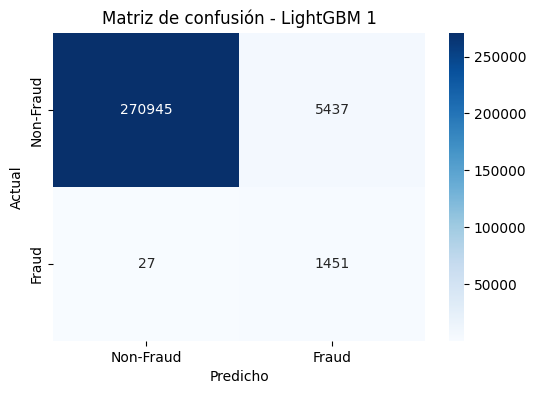

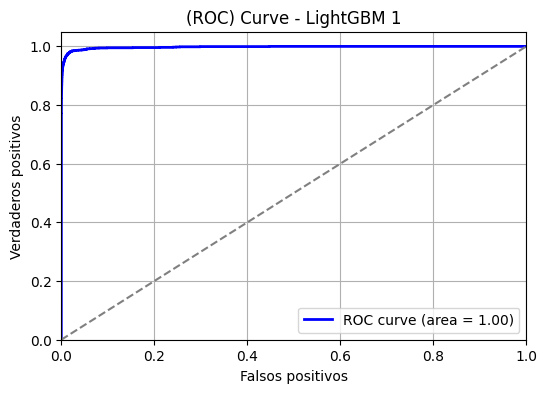

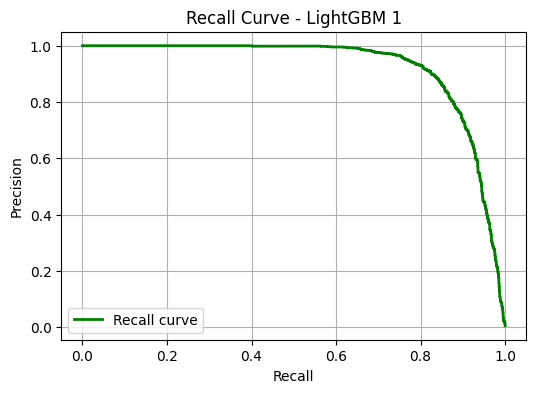

In [80]:
modelPerformance(lgmbModel_retrained, X_test_all, y_test_all, "LightGBM 1")

XBG Boost

In [81]:
trainDataBatch = xgb.DMatrix(XTrainXBGB_all, label=yTrainXBGB_all)

dtrain = xgb.DMatrix(XTrainXBGB_all, label=yTrainXBGB_all)
dtest_total = xgb.DMatrix(X_test_xbg_all, label=y_test_xbg_all)

xbgbModel_retrained = xgb.train(XBGparams, trainDataBatch, num_boost_round=100)

xbgbModel_retrained.save_model('Models/xgb_model_retrained.txt')

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Rendimiento del modelo XGBoost 1:
ROC: 0.9989798386947413
Accuracy:  0.9883475176730665
Recall: 0.9810547875064004
F1-score: 0.47024174745367536
Matriz de Confusión:
[[364246   4280]
 [    37   1916]]


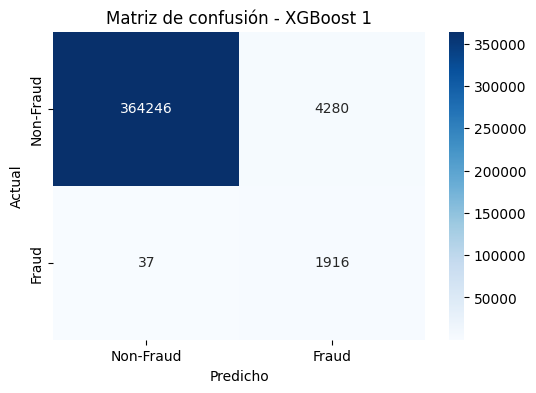

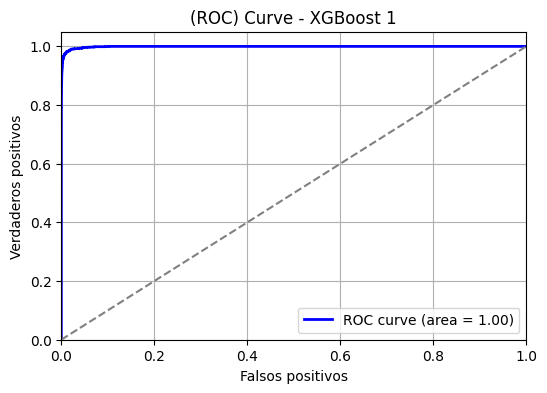

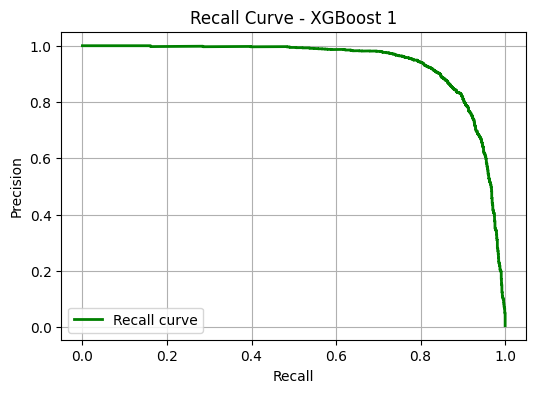

In [82]:
modelPerformance(xbgbModel_retrained, dtest_total, y_test_xbg_all, "XGBoost 1")

## Comparando Resultados

In [83]:
def evaluateModel(model, X_test, y_test, model_name):
    yPredProb = model.predict(X_test)

    fpr, tpr, thresholdsRoc = roc_curve(y_test, yPredProb)
    optimalIdxRoc = np.argmax(tpr - fpr)
    optimalThresholdRoc = thresholdsRoc[optimalIdxRoc]

    y_pred = [1 if pred > optimalThresholdRoc else 0 for pred in yPredProb]

    print(f"Rendimiento del modelo {model_name}:")
    print("Recall:", recall_score(y_test, y_pred))
    
    confMatrix = confusion_matrix(y_test, y_pred)
    print(confMatrix)
    print("")

LGBM

In [84]:
lgb_model_2019 = lgb.Booster(model_file='Models/lgb_model_2019.txt')
lgb_model_2020 = lgb.Booster(model_file='Models/lgb_model_2020.txt')
lgb_model_2020_2 = lgb.Booster(model_file='Models/lgb_model_2020_2.txt')
lgb_model_retrained = lgb.Booster(model_file='Models/lgb_model_retrained.txt')

In [85]:
evaluateModel(lgb_model_2019, X_test, y_test, "LightGBM 2019")
evaluateModel(lgb_model_2020, X_test_batch, y_test_batch, "LightGBM 2020_1")
evaluateModel(lgb_model_2020_2, X_test_batch2, y_test_batch2, "LightGBM 2020_2")
evaluateModel(lgb_model_retrained, X_test, y_test, "LightGBM Retrained")

Rendimiento del modelo LightGBM 2019:
Recall: 0.9740420271940667
[[135562   2357]
 [    21    788]]

Rendimiento del modelo LightGBM 2020_1:
Recall: 0.9137931034482759
[[22067  3686]
 [   15   159]]

Rendimiento del modelo LightGBM 2020_2:
Recall: 0.9387755102040817
[[33426   734]
 [   12   184]]

Rendimiento del modelo LightGBM Retrained:
Recall: 0.907292954264524
[[123628  14291]
 [    75    734]]



XBG Boost

In [86]:
xbgModel_2019 = xgb.Booster(model_file='Models/xgb_model_2019.txt')
xbgModel_2020 = xgb.Booster(model_file='Models/xgb_model_2020.txt')
xbgModel_2020_2 = xgb.Booster(model_file='Models/xgb_model_2020_2.txt')
xbgModel_retrained = xgb.Booster(model_file='Models/xgb_model_retrained.txt')

In [87]:
evaluateModel(xbgModel_2019, dtest_2019, y_test_xbg, "XGBoost 2019")
evaluateModel(xbgModel_2020, dtest_2020_1, y_test_xbg_batch, "XGBoost 2020_1")
evaluateModel(xbgModel_2020_2, dtest_2020_2, y_test_xbg_batch2, "XGBoost 2020_2")
evaluateModel(xbgModel_retrained, dtest_total, y_test_xbg_all, "XGBoost Retrained")

Rendimiento del modelo XGBoost 2019:
Recall: 0.9877819548872181
[[180328   3578]
 [    13   1051]]

Rendimiento del modelo XGBoost 2020_1:
Recall: 0.9957446808510638
[[34275    59]
 [    1   234]]

Rendimiento del modelo XGBoost 2020_2:
Recall: 0.9770992366412213
[[45034   512]
 [    6   256]]

Rendimiento del modelo XGBoost Retrained:
Recall: 0.9810547875064004
[[364246   4280]
 [    37   1916]]

